# Forecasting the Price of Refined sugar in the Philippines using ARIMAX model

## What is Arimax model?

ARIMAX is an extension of ARIMA model with the inclusion of the Exogeneous variables. Those exogeneous variable make the forecasting more accurate as oppose to the traditional ARIMA model.

### Components of ARIMA model
**AR** - The AutoRegressive component checks the previous data on how it affects the current data.

**MA** - The Moving Average component checks the errors of the previous data and how it affects the current data.

**I** - The Integrated is responsible for differencing the data to achieve stationarity.

#### What is Differencing?
Differencing is the Process of taking the difference of the current and previous data.
example jan = 10, feb = 12, mar = 9, apr = 11.
difference(feb) = jan - feb 

Since there is no previous value in January, it will be empty


#### What is Stationarity?
Stationarity is when the mean and variance of the time series is constant. One way to check for stationarity is through the Augmented Dickey-Fuller test. The ADF test check the existence of unit root, if it exist the time series is not stationary. Additionally, the p-value must be less than 0.05 in order to reject the existence of unit root.



The objective is to forecast the Price of refined sugar in the Phillippines, subject to the following exogeneous variables
- Production of refined sugar
- withdrawals of refined sugar
- global price of refined sugar
- exchange rate of USD to PHP
- temperature in Negros Occidental
- total precipitation in Negros Occidental

Why Negros Occidental?

Most of the sugarcane are produce in Negros Region :) 

## Load the Data set

In [76]:
from utils import *
from richutils import *
warnings.filterwarnings("ignore")

df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))
df


,Index,Price,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,TempAvg,Precipitation
Month,,,,,,,,,
2014-09-01,1,51.51,537770.0,1418420,0.1470,44.08,28,27,456.59
2014-10-01,2,51.46,1623075.0,1355836,0.1648,44.80,29,27,436.73
2014-11-01,3,51.28,2277043.0,2156729,0.1588,44.95,29,28,265.32
2014-12-01,4,51.65,2223994.0,1663150,0.1499,44.69,28,27,182.00
2015-01-01,5,51.19,2259613.0,1714490,0.1506,44.60,28,27,82.83
...,...,...,...,...,...,...,...,...,...
2024-04-01,116,85.85,1476667.0,1042072,0.2069,56.95,33,29,22.90
2024-05-01,117,85.54,590428.0,1177536,0.1880,57.76,32,29,130.78
2024-06-01,118,86.73,470766.0,1183388,0.1916,58.70,30,28,330.53


The datapoint are from September 2014 up to August 2024

In [77]:
price = df['Price']
production = df['Production']
withdrawals = df['Withdrawals']
globalPrice = df['GlobalPrice']
exchangeRate = df['ExchangeRate']
temperature = df['TempMax']
precipitation = df['Precipitation']

# I. Forecasting of Exogeneous Variables

The forecasting of exogeneous variable is done using ARIMA 

Note: Some of the evaluation metric for exogeneous variable is bit higher

In [78]:
forecast_df = pd.read_csv('exogdata.csv')
forecast_df.set_index('Month', inplace=True)

future_exog = pd.concat([forecast_df['Production'], forecast_df['Withdrawals'], forecast_df['GlobalPrice'], forecast_df['ExchangeRate'], forecast_df['TempMax'], forecast_df['Precipitation']], axis=1)


In [79]:
future_exog.head()

,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,Precipitation
Month,,,,,,
2024-09-01,7.125252e+05,7.023642e+05,0.180266,56.841096,29.466849,333.561100
2024-10-01,1.160439e+06,1.017522e+06,0.178647,56.917426,29.344605,294.436783
2024-11-01,1.469658e+06,9.729463e+05,0.178695,56.774533,29.324753,85.841673
2024-12-01,1.964885e+06,1.036543e+06,0.179967,56.819952,28.886634,64.236860
2025-01-01,2.169354e+06,1.225489e+06,0.180846,56.846766,29.402591,5.518834


The Forecasted value for the exegeneous variables are from September 2024 to August 2027

# II. ARIMAX model

The main variable we want to forecast is the Price, thus the price is the dependent variable. 

In [80]:
# Set up the Variables

y = price
exog = pd.concat([production, withdrawals, globalPrice, exchangeRate, temperature, precipitation], axis=1)

In [81]:
ADF_test(y)

P-value: 0.663961545174224 < 0.05
The time series is not stationary


P-value: 5.67356265349366e-06 < 0.05
The time series is stationary


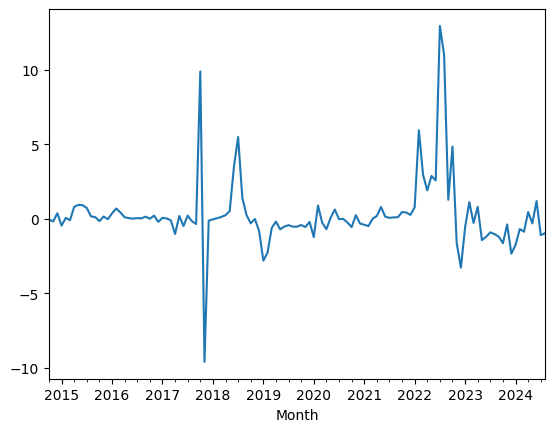

In [82]:
Differencing(y, 1)

the **I** component is 1

### Train test split

The total number of data points is 120. 80% of the data will be used for training and the remaining 20% is for testing. 20% of 120 = 24 

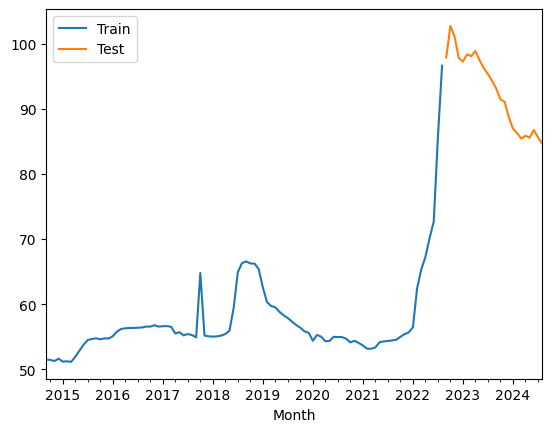

In [83]:
split = 24 
y_train, y_test = train_test_split(y, split)
exog_train, exog_test = train_test_split(exog, split)

y_train.plot()
y_test.plot()
plt.legend(['Train', 'Test'])

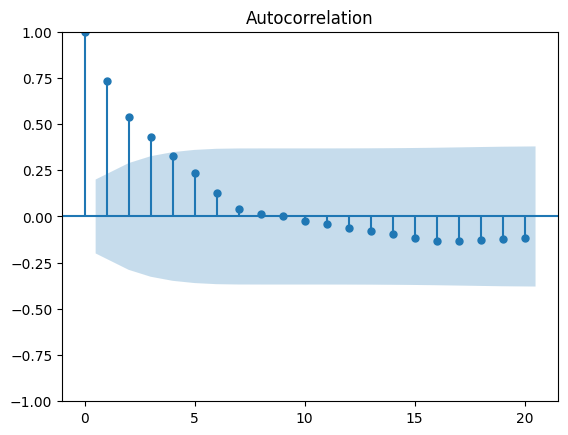

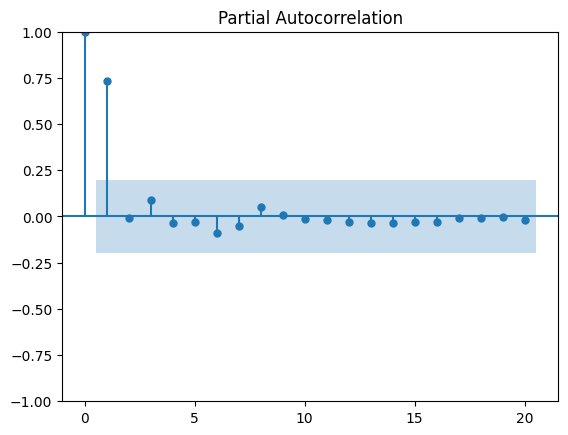

In [84]:
ACF_PACF(y_train, lags=20)

### ACF and PACF

The ACF helps to identify the **MA** or **q** component.

The PACF helps to identify the **AR** or **p** component.

In [85]:
# Evaluate other parameters
p = [0,1]
d = [1]
q = [0,1, 2, 3]

all, mape,aic, bic = Eval_possible_models(y_train, y_test, p, d, q, exog_train, exog_test)
all

,Model,Order,MSE,RMSE,MAE,MAPE,AIC,BIC
0,ARIMAX,"(0, 1, 0)",64.923800,8.057531,6.327329,7.155139,778.898776,796.775915
1,ARIMAX,"(0, 1, 1)",77.930641,8.827833,6.908510,7.823558,440.628787,461.059802
2,ARIMAX,"(0, 1, 2)",96.607855,9.828929,7.716528,8.736535,442.000051,464.984943
3,ARIMAX,"(0, 1, 3)",162.905189,12.763432,10.972386,12.288619,441.986529,467.525298
4,ARIMAX,"(1, 1, 0)",101.047121,10.052220,7.952404,8.995263,439.827864,460.258879
5,ARIMAX,"(1, 1, 1)",64.923800,8.057531,6.327329,7.155139,444.514052,467.498944
6,ARIMAX,"(1, 1, 2)",1894.080804,43.521039,38.759829,43.203198,437.928845,463.467614
7,ARIMAX,"(1, 1, 3)",653.653566,25.566649,23.828384,26.363298,440.860695,468.953341


Based on the different ARIMAX model in the table.

ARIMAX (1,1,2) has the lowest AIC

ARIMAX (1,1,0) has the lowest BIC

But among those the model with the lowest MAPE and relatively low AIC and BIC is the ARIMAX (1,1,1)

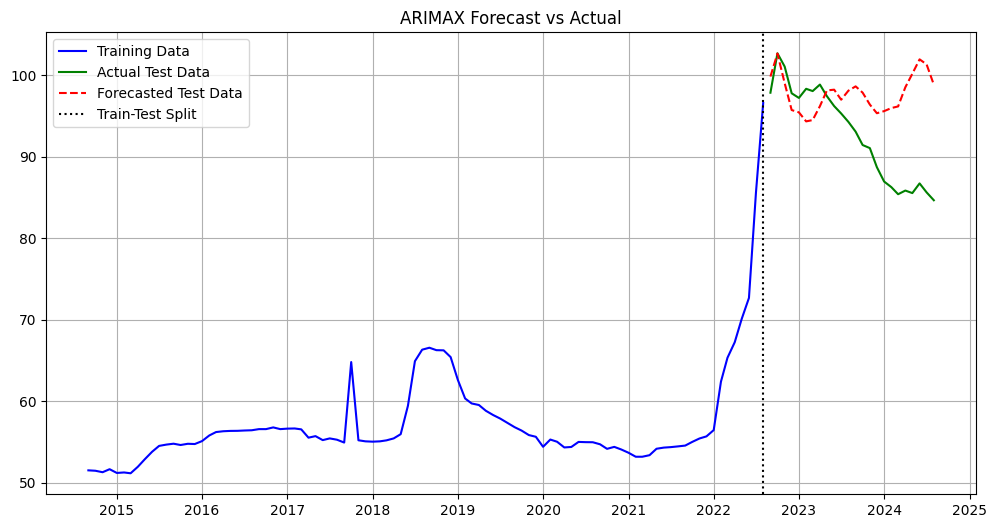

In [86]:
order = (1,1,1)
model, pred = Model(y_train,y_test, order, exog_train, exog_test) 

In [87]:
test_results = pd.DataFrame({'Test': y_test, 'Pred': pred})
test_results.head()

,Test,Pred
2022-09-01,97.86,99.843077
2022-10-01,102.70,102.667798
2022-11-01,101.07,99.032102
2022-12-01,97.79,95.733383
2023-01-01,97.22,95.450156


,lb_stat,lb_pvalue
1,0.51979,0.470931


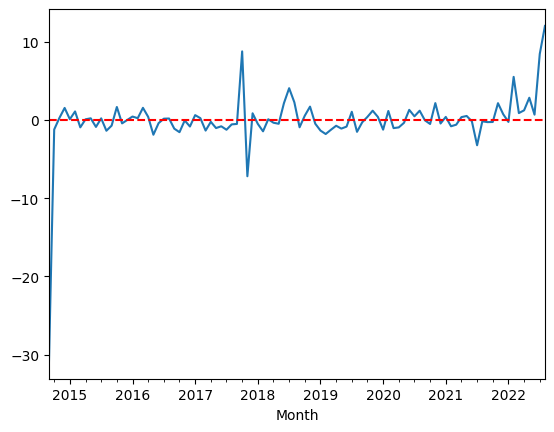

In [88]:
resid = Residuals(model)
LjungBox(resid, lags=1)

In [89]:
# Evaluate the model

Evaluate(y_train, y_test, order, exog_train, exog_test)

Evaluation of ARIMAX(1, 1, 1)
MSE: 64.9238
MAE: 6.3273
RMSE: 8.0575
MAPE: 7.16%
AIC: 444.51
BIC: 467.50


My Evaluation:

7% MAPE is OK

MAPE < 10% is good


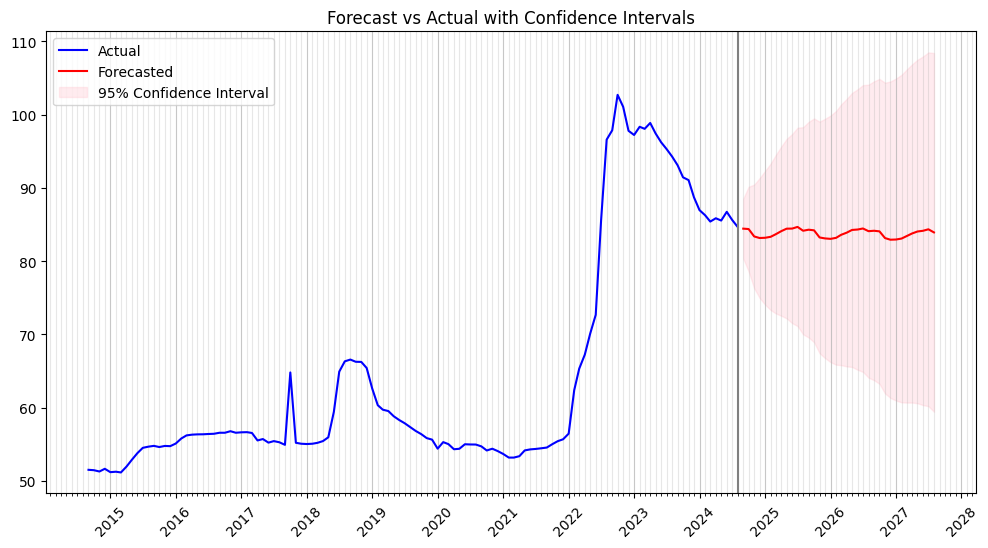

In [90]:
forecast, model = Forecast(y, order, 36, exog, future_exog)
confidence = model.get_forecast(steps=36, exog=future_exog).conf_int()

Forecasted_plot(y, forecast, confidence.values)

In [91]:
forecast_df = pd.DataFrame(forecast, columns=['Forecast'])
forecast_df.head(12)

,Forecast
2024-09-01,84.433421
2024-10-01,84.379318
2024-11-01,83.370800
2024-12-01,83.155558
2025-01-01,83.186237
2025-02-01,83.320250
2025-03-01,83.666603
2025-04-01,84.088092
2025-05-01,84.429344
2025-06-01,84.444044


In [92]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -259.558
Date:                Mon, 28 Apr 2025   AIC                            537.117
Time:                        21:33:36   BIC                            562.129
Sample:                    09-01-2014   HQIC                           547.273
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Production    -1.414e-07   6.74e-07     -0.210      0.834   -1.46e-06    1.18e-06
Withdrawals    3.116e-07   7.65e-07      0.408      0.684   -1.19e-06    1.81e-06
GlobalPrice       2.9871      0.001   3888.005      0.000       2.986       2.989
ExchangeRate      1.3063      0.297      4.395      0.000       0.724       1.889
TempMax           0.3417      0.370      0.923      0.356      -0.384       1.067
Precipitation     0.0036      0.002      1.790      0.073      -0.000       0.008
ar.L1                  0      0.044          0      1.000      -0.086       0.086
ma.L1                 -0      0.044         -0      1.000      -0.086       0.086
sigma2            4.3349      0.388     11.175      0.000       3.575       5.095
===================================================================================
Ljung-Box (L1) (Q):                   3.14   Jarque-Bera (JB):               833.85
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             2.41
Prob(H) (two-sided):                  0.02   Kurtosis:                        15.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+18. Standard errors may be unstable.
"""

In [93]:
latest_actual_price = [84, 83.15,83.13, 82.83, 83.65, 83.07, 83.14, 83.49] # retrieved from department of Agriculture price monitoring
forecasted_price = forecast.head(8).values.tolist()


from sklearn.metrics import mean_absolute_percentage_error as mape
mape_value = mape(latest_actual_price, forecasted_price) * 100
print(f'MAPE: {mape_value:.2f}%')


MAPE: 0.61%


The forecasted price vs the latest actual price shows a Mean absolute percentage error of 0.61%. That's fucking good